In [87]:
# Importing stuff
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
from qiskit.extensions import UnitaryGate
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from tqdm.notebook import tqdm
import pickle

# 2-positional qubit grayscale image

In [156]:
# new quantum circuit with 2 positional qubits (2^2 = 4 pixels) and one color qubit
qc = QuantumCircuit(3)
qc.h(0)
qc.h(1)

# theta values range from 0 to pi/2, and correspond to 0 to 255 in RGB
# θ = 0: channel off (black)
# θ = pi/4: channel halfway on (gray)
# θ = pi/2: channel fully on (white)

# Pixel 1
theta = 0
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)
qc.barrier()

# the positional qubits are a binary representation of the # of the current pixel
# this x gate changes the current pixel from 00 -> 01
qc.x(1)

# Pixel 2
theta = pi/6
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)
qc.barrier()

# 01 -> 10
qc.x(0)
qc.x(1)

# Pixel 3
theta = pi/3
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)
qc.barrier()

# 10 -> 11
qc.x(1)

# Pixel 4
theta = pi/2
qc.cry(theta,0,2)
qc.cx(0,1)
qc.cry(-theta,1,2)
qc.cx(0,1)
qc.cry(theta,1,2)

qc.measure_all()

qc.draw()

┌───┐                                      ░                      »
   q_0: ┤ H ├────■──────■─────────────■────────────░───────────■───────■──»
        ├───┤    │    ┌─┴─┐         ┌─┴─┐          ░ ┌───┐     │     ┌─┴─┐»
   q_1: ┤ H ├────┼────┤ X ├────■────┤ X ├────■─────░─┤ X ├─────┼─────┤ X ├»
        └───┘┌───┴───┐└───┘┌───┴───┐└───┘┌───┴───┐ ░ └───┘┌────┴────┐└───┘»
   q_2: ─────┤ Ry(0) ├─────┤ Ry(0) ├─────┤ Ry(0) ├─░──────┤ Ry(π/6) ├─────»
             └───────┘     └───────┘     └───────┘ ░      └─────────┘     »
meas: 3/══════════════════════════════════════════════════════════════════»
                                                                          »
«                                     ░ ┌───┐                                 »
«   q_0: ──────────────■──────────────░─┤ X ├─────■───────■────────────────■──»
«                    ┌─┴─┐            ░ ├───┤     │     ┌─┴─┐            ┌─┴─┐»
«   q_1: ─────■──────┤ X ├─────■──────░─┤ X ├─────┼─────┤ X ├─────■──────┤ X ├»
«        ┌────┴─────┐└───┘┌────┴────┐ ░ └───┘┌────┴────┐└───┘┌────┴─────┐└───┘»
«   q_2: ┤ Ry(-π/6) ├─────┤ Ry(π/6) ├─░──────┤ Ry(π/3) ├─────┤ Ry(-π/3) ├─────»
«        └──────────┘     └─────────┘ ░      └─────────┘     └──────────┘     »
«meas: 3/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«                    ░                                                   ░ ┌─┐»
«   q_0: ────────────░───────────■───────■────────────────■──────────────░─┤M├»
«                    ░ ┌───┐     │     ┌─┴─┐            ┌─┴─┐            ░ └╥┘»
«   q_1: ─────■──────░─┤ X ├─────┼─────┤ X ├─────■──────┤ X ├─────■──────░──╫─»
«        ┌────┴────┐ ░ └───┘┌────┴────┐└───┘┌────┴─────┐└───┘┌────┴────┐ ░  ║ »
«   q_2: ┤ Ry(π/3) ├─░──────┤ Ry(π/2) ├─────┤ Ry(-π/2) ├─────┤ Ry(π/2) ├─░──╫─»
«        └─────────┘ ░      └─────────┘     └──────────┘     └─────────┘ ░  ║ »
«meas: 3/═══════════════════════════════════════════════════════════════════╩═»
«                                                                           0 »
«              
«   q_0: ──────
«        ┌─┐   
«   q_1: ┤M├───
«        └╥┘┌─┐
«   q_2: ─╫─┤M├
«         ║ └╥┘
«meas: 3/═╩══╩═
«         1  2

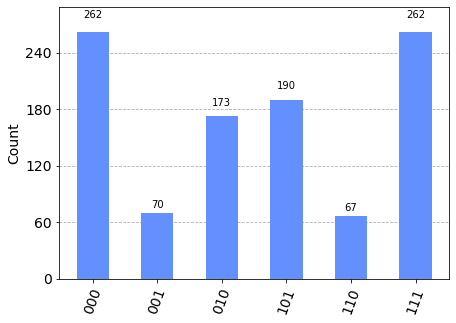

In [171]:
# run the circuit on Qiskit's AER sim
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim)
r = aer_sim.run(qc_transpiled).result()
c = r.get_counts(qc)
plot_histogram(c, sort='asc')

### Decoding images
Below is a simplified version of the general decoder in the next section.
For grayscale, each pixel's value is: 

$$\frac{(\text{# of output states where color qubit == 1}) * 255}{\text{Total # of output states}}$$

Where output states refers to states with the positional qubits matching the current pixel, i.e \*01 matches all states concerning the second pixel.

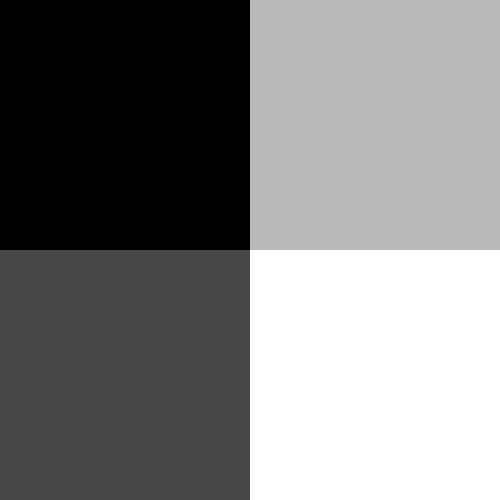

In [172]:
color = np.zeros(4)
total = np.zeros(4)
for state in c:
    i = int(state[-2:], 2)
    total[i] += c[state]
    if state[0] == '1':
        color[i] += c[state]
        
w = 2
h = 2
img = Image.new(mode='RGB', size=(w, h))
for i in range(4):
    x = int((color[i] / total[i] if total[0] != 0 else 0) * 255)
    img.putpixel((i%w, int(i/w)), (x, x, x))
img = img.resize((500,int((h/w)*500)), Image.NEAREST)
display(img)

# 2-positional qubit color image

Same deal, but now, instead of only one qubit for color, there are three, allowing for RGB encoding.

In [228]:
# new quantum circuit with 2 positional qubits (2^2 = 4 pixels) and three color qubits
qc = QuantumCircuit(5)
qc.h(0)
qc.h(1)

# helper function to squash a lot of redundant code
def encodePixel(r, g, b):
    rtheta = r/255 * (pi/2)
    gtheta = g/255 * (pi/2)
    btheta = b/255 * (pi/2)
    
    qc.cry(rtheta,0,2)
    qc.cx(0,1)
    qc.cry(-rtheta,1,2)
    qc.cx(0,1)
    qc.cry(rtheta,1,2)

    qc.cry(gtheta,0,3)
    qc.cx(0,1)
    qc.cry(-gtheta,1,3)
    qc.cx(0,1)
    qc.cry(gtheta,1,3)

    qc.cry(btheta,0,4)
    qc.cx(0,1)
    qc.cry(-btheta,1,4)
    qc.cx(0,1)
    qc.cry(btheta,1,4)

# Pixel 1
encodePixel(255, 0, 0)

# 00 -> 01
qc.x(1)

# Pixel 2
encodePixel(0, 255, 0)

# 01 -> 10
qc.x(0)
qc.x(1)

# Pixel 3
encodePixel(0, 0, 255)

# 10 -> 11
qc.x(1)

# Pixel 4
encodePixel(255, 255, 255)

qc.measure_all()

qc.draw()

┌───┐                                                          »
   q_0: ┤ H ├─────■───────■────────────────■─────────────────■──────■──»
        ├───┤     │     ┌─┴─┐            ┌─┴─┐               │    ┌─┴─┐»
   q_1: ┤ H ├─────┼─────┤ X ├─────■──────┤ X ├─────■─────────┼────┤ X ├»
        └───┘┌────┴────┐└───┘┌────┴─────┐└───┘┌────┴────┐    │    └───┘»
   q_2: ─────┤ Ry(π/2) ├─────┤ Ry(-π/2) ├─────┤ Ry(π/2) ├────┼─────────»
             └─────────┘     └──────────┘     └─────────┘┌───┴───┐     »
   q_3: ─────────────────────────────────────────────────┤ Ry(0) ├─────»
                                                         └───────┘     »
   q_4: ───────────────────────────────────────────────────────────────»
                                                                       »
meas: 5/═══════════════════════════════════════════════════════════════»
                                                                       »
«                                                                             »
«   q_0: ───────────■───────────────■──────■─────────────■───────────────■────»
«                 ┌─┴─┐             │    ┌─┴─┐         ┌─┴─┐             │    »
«   q_1: ────■────┤ X ├────■────────┼────┤ X ├────■────┤ X ├────■────────┼────»
«            │    └───┘    │        │    └───┘    │    └───┘    │    ┌───┴───┐»
«   q_2: ────┼─────────────┼────────┼─────────────┼─────────────┼────┤ Ry(0) ├»
«        ┌───┴───┐     ┌───┴───┐    │             │             │    └───────┘»
«   q_3: ┤ Ry(0) ├─────┤ Ry(0) ├────┼─────────────┼─────────────┼─────────────»
«        └───────┘     └───────┘┌───┴───┐     ┌───┴───┐     ┌───┴───┐         »
«   q_4: ───────────────────────┤ Ry(0) ├─────┤ Ry(0) ├─────┤ Ry(0) ├─────────»
«                               └───────┘     └───────┘     └───────┘         »
«meas: 5/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                          »
«   q_0: ───────■─────────────■────────────────■───────■────────────────■──»
«        ┌───┐┌─┴─┐         ┌─┴─┐              │     ┌─┴─┐            ┌─┴─┐»
«   q_1: ┤ X ├┤ X ├────■────┤ X ├────■─────────┼─────┤ X ├─────■──────┤ X ├»
«        └───┘└───┘┌───┴───┐└───┘┌───┴───┐     │     └───┘     │      └───┘»
«   q_2: ──────────┤ Ry(0) ├─────┤ Ry(0) ├─────┼───────────────┼───────────»
«                  └───────┘     └───────┘┌────┴────┐     ┌────┴─────┐     »
«   q_3: ─────────────────────────────────┤ Ry(π/2) ├─────┤ Ry(-π/2) ├─────»
«                                         └─────────┘     └──────────┘     »
«   q_4: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                 ┌───┐                     »
«   q_0: ───────────────■──────■─────────────■────┤ X ├───────────■──────■──»
«                       │    ┌─┴─┐         ┌─┴─┐  └───┘  ┌───┐    │    ┌─┴─┐»
«   q_1: ─────■─────────┼────┤ X ├────■────┤ X ├────■────┤ X ├────┼────┤ X ├»
«             │         │    └───┘    │    └───┘    │    └───┘┌───┴───┐└───┘»
«   q_2: ─────┼─────────┼─────────────┼─────────────┼─────────┤ Ry(0) ├─────»
«        ┌────┴────┐    │             │             │         └───────┘     »
«   q_3: ┤ Ry(π/2) ├────┼─────────────┼─────────────┼───────────────────────»
«        └─────────┘┌───┴───┐     ┌───┴───┐     ┌───┴───┐                   »
«   q_4: ───────────┤ Ry(0) ├─────┤ Ry(0) ├─────┤ Ry(0) ├───────────────────»
«                   └───────┘     └───────┘     └───────┘                   »
«meas: 5/═══════════════════════════════════════════════════════════════════»
«                                                                           »
«   

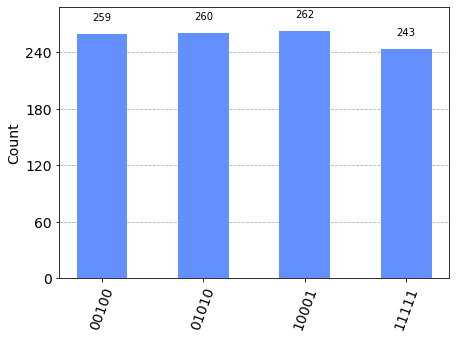

In [229]:
# run the circuit on Qiskit's AER sim
aer_sim = Aer.get_backend('aer_simulator')
qc_transpiled = transpile(qc, aer_sim)
r = aer_sim.run(qc_transpiled).result()
c = r.get_counts(qc)
plot_histogram(c, sort='asc')

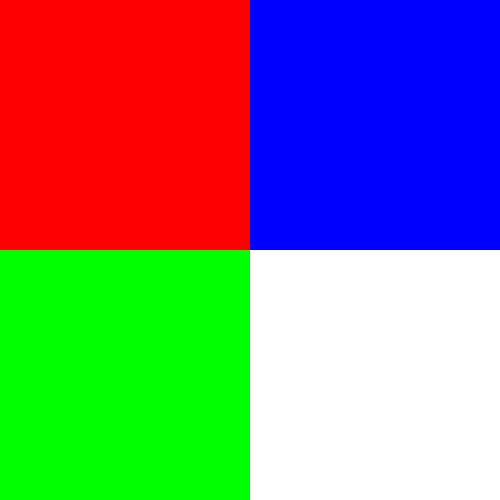

In [231]:
red = np.zeros(4)
green = np.zeros(4)
blue = np.zeros(4)
total = np.zeros(4)
for state in c:
    i = int(state[-2:], 2)
    total[i] += c[state]
    if state[2] == '1':
        red[i] += c[state]
    if state[1] == '1':
        green[i] += c[state]
    if state[0] == '1':
        blue[i] += c[state]
        
w = 2
h = 2
img = Image.new(mode='RGB', size=(w, h))
for i in range(4):
    red[i] = ((red[i] / total[i]) * 255) if total[i] != 0 else 0
    green[i] = ((green[i] / total[i]) * 255) if total[i] != 0 else 0
    blue[i] = ((blue[i] / total[i]) * 255) if total[i] != 0 else 0
    img.putpixel((i%w, int(i/w)), (int(red[i]), int(green[i]), int(blue[i])))
img = img.resize((500,int((h/w)*500)), Image.NEAREST)
display(img)

# n-positional qubit color image*

**kinda cheating with Qiskit's UnitaryGates but...* 🤷‍♂️

---

See report for more rigorous detail, but essentially, it's possible to make a general n-positional qubit/2<sup>n</sup> pixel image by having Qiskit generate the n-qubit controlled rotation matrices.\
Decomposing n-qubit controlled R<sub>y</sub>(2θ) into CNOTs and controlled R<sub>y</sub>'s is possible, but it gets exponentially more difficult as you add more control qubits.\
The 2-positional qubit decomposition is used above, but the below uses the R<sub>y</sub> matrix controlled to n qubits via `UnitaryGate.control(n)`.

For this implementation, RGB color is implemented by simply having 3 color qubits, and encoding them separately.\
Methods exist to encode all three channels into one color qubit (FRQCI for example), but that is left as an exercise for the reader.

In [223]:
# number of positional qubits, allowing for 2^n pixels
n = 6

### n-qubit controlled gates
gates.bin is a pickle dump of a 2D array indexed by the number of positional qubits (up to 6), then the color value (0-255).\
That returns an n-qubit controlled rotation gate that encodes that color value.\
The array was generated with the following code:\
`gates = [[], [], [], [], [], [], []]
for N in range(6):
    N += 1
    gates[N] = []
    for i in range(256):
        theta = i/255*(pi/2)
        gates[N].append(UnitaryGate([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ], 'Ry('+str(round(theta, 2))+')').control(N))
pickle.dump(gates, open('gates.bin', 'wb'))`

In [221]:
# gates = pickle.load(open('gates.bin', 'rb'))

In [225]:
# function that takes a quantum circuit and three color values from 0-255,
# and encodes the colors into the circuit via the rotation gates
def encode(qc, r, g, b):
    qs = [i for i in range(n)]
    # append the gate for the closest whole color value,
    # controlled on the positional qubits and targeting the
    # corresponding color
    qc.append(
        gates[n][round(r)], 
        qs + [n]
    )
    qc.append(
        gates[n][round(g)], 
        qs + [n + 1]
    )
    qc.append(
        gates[n][round(b)], 
        qs + [n + 2]
    )

# an array for each color channel, with 2^n entries, one for each pixel
r = np.concatenate((np.linspace(255, 0, 2**(n-1)), np.zeros(2**(n-1))))
g = np.concatenate((np.zeros(2**(n-1)), np.linspace(0, 255, 2**(n-1))))
b = np.concatenate((np.linspace(0, 255, 2**(n-1)), np.linspace(255, 0, 2**(n-1))))

# make new quantum circuit with n positional qubits and 3 color qubits
qcA = QuantumCircuit(n+3)
# hadamard the positional qubits
qcA.h(i for i in range(n))

# for each pixel...
for i in range(2**n):
    qcA.barrier()
    # encode the bit representation of the current pixel into the positional qubits
    if i != 0:
        for j, x in enumerate(bin(i ^ (i-1))[2:].zfill(n)):
            if x == '1':
                qcA.x(n - j - 1)
    # encode the pixel!
    encode(qcA, r[i], g[i], b[i])

qcA.measure_all()

# At n >= 4, drawing this massive circuit becomes kinda dumb
# qcA.draw()

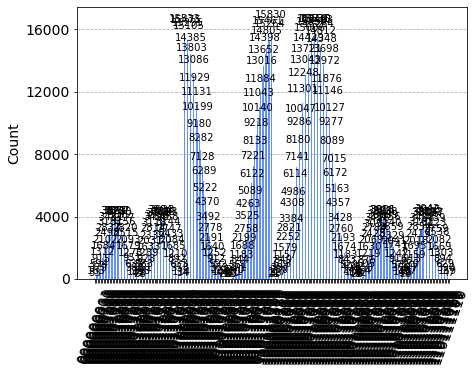

In [226]:
# run the circuit on Qiskit's AER sim
aer_sim = Aer.get_backend('aer_simulator')
t_qcA = transpile(qcA, aer_sim)
# 10^n shots seems to give accurate colors without taking forever
result = aer_sim.run(t_qcA, shots=10**n).result()
counts = result.get_counts(qcA)
plot_histogram(counts, sort='asc')

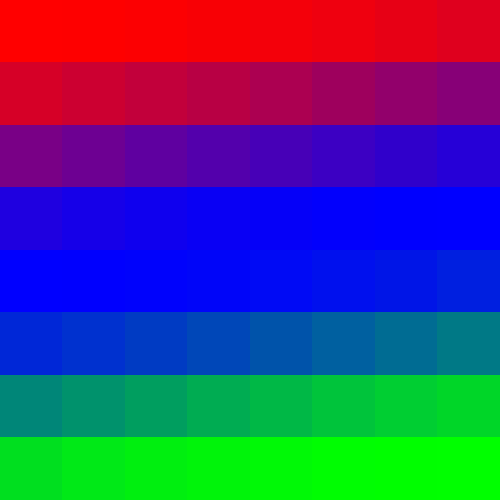

In [227]:
red = np.zeros(2**n)
green = np.zeros(2**n)
blue = np.zeros(2**n)
total = np.zeros(2**n)
for state in counts:
    i = int(state[-n:], 2)
    total[i] += counts[state]
    if state[2] == '1':
        red[i] += counts[state]
    if state[1] == '1':
        green[i] += counts[state]
    if state[0] == '1':
        blue[i] += counts[state]
        
w = 2**math.floor(n/2)
h = 2**math.ceil(n/2)
img = Image.new(mode='RGB', size=(w, h))
for i in range(2**n):
    red[i] = ((red[i] / total[i]) * 255) if total[i] != 0 else 0
    green[i] = ((green[i] / total[i]) * 255) if total[i] != 0 else 0
    blue[i] = ((blue[i] / total[i]) * 255) if total[i] != 0 else 0
    img.putpixel((i%w, int(i/w)), (int(red[i]), int(green[i]), int(blue[i])))
img = img.resize((500,int((h/w)*500)), Image.NEAREST)
display(img)